# Example workflow of process sensitivity analiysis using Sobol-G* function

This jupyter file applies both variance-based sensitivity analysis (VBSA) and mutil-model difference-based sensitivity analysis(MMDS) to a mathematical Sobol-G* function (Saltelli et al. 2010) with three processes.

Prepared by Jing Yang and Ming Ye at Florida State University, 2020. Mail to: mye@fsu.edu.

The Sobol-G* function is defined as:

$$G^*(X_1,...,X_k;a_1,...a_k;\delta_1,...,\delta_k;\alpha_1,...,\alpha_k)=\prod_{i=1}^k g^*_i$$

$$g^*_i=\frac{(1+\alpha_i)\times |2(X_i+\delta_i-I[X_i+\delta_i])-1|^{\alpha_i}+a_i}{1+a_i}$$

where $X_i$ are input parameters, all uniformly distributed in [0, 1], $a_i \in R^+$  is traditional Sobol-G function parameter; $\delta_i \in [0, 1]$  and $\alpha_i$  are shift and curvature parameters,  respectively; $I[X_i+\delta_i]$ is the integer part of $X_i+\delta_i$ (Saltelli et al. 2010). The two parameters $\alpha_i$ and $a_i$ together determine the degree of the influence of a parameter.The smaller the two parameters, the higher total parameter sensitivity index and thus the less influential of the parameter. 

Each element in the products is treated as one process and the system model output is the product of the outputs from the processes. The shift parameter $\delta_i$ is set to be zero and only three processes, $g^*_1$, $g^*_2$, and $g^*_3$ are considered.  Each process is interpreted by two equally weighted alternative process models. The curvature parameters are $\alpha_i^1=1$  and $\alpha_i^2=2$  where the subscript i denote the i-th (i=1, 2, and 3) process and the superscript 1 and 2 denotes the first and second alternative process model, respectively. The other parameters used are $a_1^1=1.5$, $a_1^2=1.2$, $a_2^1=4.2$, $a_2^2=1.8$, $a_3^1=6.5$, and $a_3^2=2.3$ . Note the two alternative process models use the same parameter $X_i$.Details about the configuration of this model are reffered to Yang et al. (2020). 

The analytical process sensitivity measures are listed in the fllowing tabel:


|  Variance-based first-order and total effect process sensitivty indices (%)   | $g_1^*$  | $g_2^*$ | $g_3^*$|
|  --------  | --------  |  --------  | --------  |
| $PS_K$  | 49.85 | 26.08| 18.01|
| $PS_{TK}$  | 54.79 | 30.07| 21.23|


|  Mutli-model difference-based mean and varaince of output difference   | $g_1^*$  | $g_2^*$ | $g_3^*$|
|  --------  | --------  |  --------  | --------  |
| Mean  | 37.28 | 26.38| 21.75|
| Variance  | 10.13 | 6.23| 4.58|

## 1. Load basic modules

In [1]:
import numpy as np
import numba as nb

## 2. Define the multiple system model configuration

### 2.1 Define the process models

Since all the process models use a similar mathematical expression except that the paramters  𝑎  and  𝛼  are different, there is no need to define the process model functions for each process model. We can directly change the parameter values in the system model function.

In [2]:
alpha = np.array([[1,  2], [1, 2], [1, 2]])
a = np.array([[1.5, 1.2], [4.2, 1.8], [6.5, 2.3]])

### 2.2 Define the system model function

In [3]:
@nb.njit
def evaluate(values, alpha, a):
    """Sobol G*-function.

    .. [1] Saltelli, A., Annoni, P., Azzini, I., Campolongo, F., Ratto, M., 
           Tarantola, S., 2010. Variance based sensitivity analysis of model 
           output. Design and estimator for the total sensitivity index. 
           Computer Physics Communications 181, 259–270. 
           https://doi.org/10.1016/j.cpc.2009.09.018

    Parameters
    ----------
    values : 1D numpy.ndarray
        input variables
    alpha : 1D numpy.ndarray
        parameter values
    a : 1D numpy.ndarray
        parameter values

    Returns
    -------
    Y : Result of G*-function
    """
    
    ltz = values < 0
    gto = values > 1

    if ltz.any() == True:
        raise ValueError("Sobol G function called with values less than zero")
    elif gto.any() == True:
        raise ValueError("Sobol G function called with values greater than one")
        
    gi = ((1 + alpha) * np.power(np.abs(2 * values - 1), alpha) + a) / (1 + a)

    return np.prod(gi)

### 2.3 Define the model frames

In [4]:
# Import sammpy
import sammpy as sm

# System model class
model = sm.model()
model.name = 'sobol_G_star'
model.frames = {'names'  : ['g1_star', 'g2_star', 'g3_star'],
                'options': [['g1_star_1', 'g1_star_2'], 
                            ['g2_star_1', 'g2_star_2'],
                            ['g3_star_1', 'g3_star_2']],
                'weights': [[0.5, 0.5], 
                            [0.5, 0.5],
                            [0.5, 0.5]]}

# Constant variables used in the simulations
model.env = {'delta': [0, 0, 0]}
             
# Random variabs used in the simulation
model.pars = {'names': ['X1', 'X2', 'X3'],
              'bounds':[[0.1, 1.0], [0.1, 1.0], [0.1, 1.0]],
              'dists': ['unif', 'unif', 'unif']}

# system model functions 
model.func = evaluate

## 3. Generate ouputs with parametric and process model uncertainty

### 3.1 Generate the parameter realizations 

The samples are genertaed using SALib with Saltelli's sampling sampling scheme. Saltelli's scheme extends the Sobol sequence in a way to reduce the error rates in the resulting sensitivity index calculations. For more detials, readers are refered to https://salib.readthedocs.io/en/latest/index.html#. The generated parameter values can be visualized using histograms.

In [5]:
N = 500       # Number of sample realizations
param_values = model.sample(nobs=N, method='saltelli', seed=933090936)

The distribution of the generated parameters can be dispalyed using sammpy.plotting.

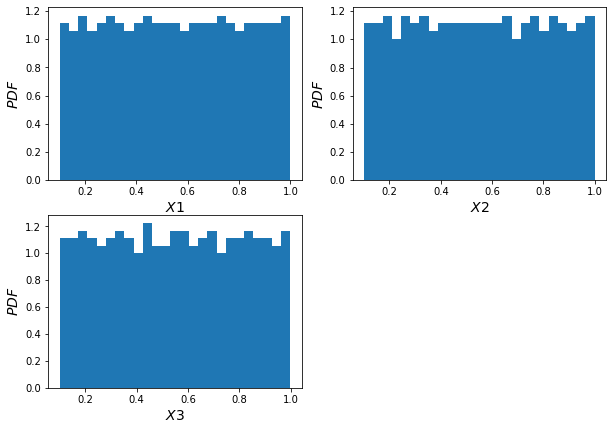

In [6]:
from sammpy.plotting import hist
hist.plot(model, param_values)

### 3.2 Generate the outputs

The outputs are generated using considering both parametric and process model uncertainty. The outputs are stored in an array of whihc the size is 2 x N x 2 x N x 2 x N in this case, corresponding to the two $g_1^*$ process models and their N parameter realizaitons, the two $g_2^*$ process models and their N parameter realizations, and the two $g_3^*$ process models and their N parameter realizations, respectively. The advantage of storing data in this way is we can compute all the varianced-based sensitivy indices including the first-order, total-effect, second-order and higher-order ones of all processes using this array. The disadvantage is storing such a array requirs a large memory size since it is high demensional.  

In [7]:
# The number of the process models for each of the three processes
Ma, Mb, Mc = 2, 2, 2               

# Compute the model outputs
@nb.njit(parallel=True)
def cmpt_Y():
    # Initilize an array
    Y = np.zeros((Ma, N, Mb, N, Mc, N))

    for i in range(Ma):
        for j in nb.prange(N):
            for k in range(Mb):
                for l in nb.prange(N):
                    for m in range(Mc):
                        for n in nb.prange(N):
                            values = np.array([param_values[j, 0], param_values[l, 1], param_values[n, 2]])
                            Y[i, j, k, l, m, n] = evaluate(values, np.array([alpha[0, i], alpha[1, k], alpha[2, m]]), np.array([a[0, i], a[1, k], a[2, m]]))
    return Y
Y = cmpt_Y()

## 4 Process sensitivity analysis

The sensitivity of the parameters under individual system model can be performed using many sensitivity analysis tools such as SALib thus it is not shown here. Below, we use the model outputs generated in the last step to evaluate the process sensitivity by using both variance-based method and the difference-based method.

### 4.1 Sensitivity analysis using variance-based method

By decomposing the variance, the first-order process sensitivity index is defined by Dai et al. (2017) as

$$PS_K=\frac{V_{M_K}(E_{M_{\sim K}}[\Delta|M_K])}{V(\Delta)}$$

The total effect process sensitivty index is defined by Yang et al. (2020) as

$$PS_{TK}=\frac{E_{M_{\sim K}}(V_{M_{K}}[\Delta|M_{\sim K}])}{V(\Delta)}$$

The sensitivy indices including ones of both first-order and total effect can be computed using the function of vbsa.analysis. The function takes the model object and output values as input parameters and return a dictionary with keys "PSK" and "PSTK",  corresponding to the first-order and total effect process sensitivty index, respectively. Each entry is a array of size of the number of process. The "print_to_console" is used to control the dispaly of the computing information.

In [8]:
from sammpy.analyze import vbsa
Ret_vbsa = vbsa.analyze(model, Y, print_to_console=True)

Runing VBSA first-order process sensitivy analysis...
Runing VBSA total-effect process sensitivy analysis...
Process 	 PSK 	 PSTK
g1_star 	 0.5159 	 0.5594
g2_star 	 0.2574 	 0.2923
g3_star 	 0.1746 	 0.2013


The results can be displayed using the bar plots.

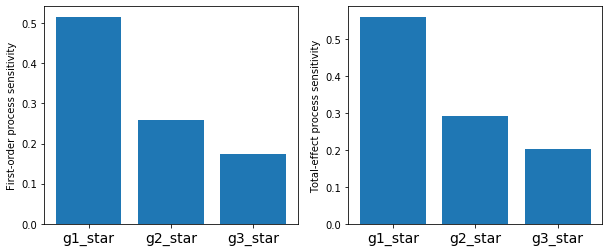

In [9]:
from sammpy.plotting import bar
bar.plot(model, Ret_vbsa)

### 4.2 Sensitivity analysis using difference-based method

The purpose of the sensitivity analysis using difference-based method is very similar to the total effect-process senistivity analysis,that is to screen the non-influential processes to simplify the model.Inspired by the Morris elementary effect, the mean and variance of the absolute output difference caused by the variation (uncertainty) of a process K when the other process are fixed can be used to measure the sensitivity of this process:

$$E(d\Delta|K)=E_{\sim K}E_{P_K}(d\Delta|\sim K)\\
 \qquad\qquad\,\,=E_{M_{\sim K}}E_{P_{M_K}}(d\Delta|M_{\sim K})$$
 
$$V(d\Delta|K)=E_{\sim K}V_{P_K}(d\Delta|\sim K)+ V_{\sim K}E_{P_K}(d\Delta|\sim K)\\
 \qquad\qquad\,\,\,\,\,\,\,\,=E_{M_{\sim K}}V_{P_{M_K}}(d\Delta|M_{\sim K}) + V_{M_{\sim K}}E_{P_{M_K}}(d\Delta|M_{\sim K})$$
 
                                                                       

In [10]:
from sammpy.analyze import mmds
Ret_mmds = mmds.analyze(model, Y, print_to_console=True)

Runing MMDS difference-based process sensitivy analysis...
Process 	 mean 	 variance
g1_star 	 0.3104 	 0.0709
g2_star 	 0.2152 	 0.0411
g3_star 	 0.1756 	 0.0294


The results can be displayed using the scatter plots.

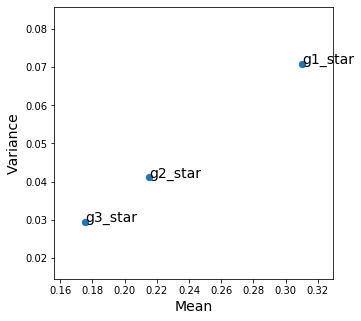

In [11]:
from sammpy.plotting import dotty
dotty.plot(model, Ret_mmds)